# Sources

# Module: Tools

## Raw Citibike Data

https://s3.amazonaws.com/tripdata/2020-citibike-tripdata.zip

https://citibikenyc.com/system-data

## Subway Data
https://data.ny.gov/Transportation/MTA-Subway-Stations/39hk-dx4f/data_preview

##  Module: Libraries

In [ ]:
! pip install pycaret[full]
! pip install geopy
! pip install diskcache

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipydisplay
import warnings
import json
import datetime
import time
from sklearn.metrics.pairwise import haversine_distances
from abc import ABC, abstractmethod
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from geopy.distance import geodesic
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import OneHotEncoder
from pycaret.regression import *
from typing import Callable, Any, List, Tuple
import functools
import folium
from folium.plugins import Fullscreen
from IPython.display import IFrame

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
color = sns.color_palette("tab10")
sns.set_style('darkgrid')

## Raw Data Provider

In [ ]:
class DataProvider():
  df_raw: pd.DataFrame
  last_file_name: str
  identifier: str

  def __init__(self):
    self.df_raw = pd.DataFrame()
    self.last_file_name = ''

  def load_jan2020(self):
    ''' This function is a shortcut '''
    ! wget https://s3.amazonaws.com/tripdata/2020-citibike-tripdata.zip
    ! unzip 2020-citibike-tripdata.zip
    ! unzip 2020-citibike-tripdata/202001-citibike-tripdata.zip # January/2020 data

    display('Clearing folders and raw files')
    ! rm -rf 2020-citibike-tripdata.zip
    ! rm -rf 2020-citibike-tripdata/
    ! rm -rf 202001-citibike-tripdata.zip

    ipydisplay.clear_output()
    display('Files ready')
    self.last_file_name = '202001-citibike-tripdata_1.csv'
    self.identifier = "Jan/2020"
    return self


  def load(self, year:str, month:str):
    '''This function is an API. The user requests some data and the magic happens underneath'''
    display(f'Downloading: {year}/{month}')
    file_name = f"{year}-citibike-tripdata"
    ! wget https://s3.amazonaws.com/tripdata/{file_name}+".zip"
    ! unzip {file_name}+".zip"
    ! unzip {file_name}/{year}-{month}-citibike-tripdata.zip

    ipydisplay.clear_output()
    display('Files ready')
    self.last_file_name = file_name+'.csv'
    return self

  def get_df(self) -> pd.DataFrame:
    if self.df_raw.empty:
      with open(self.last_file_name, 'r') as file:
        self.df_raw = pd.read_csv(file, parse_dates=['started_at', 'ended_at'])
    return self.df_raw.copy()

In [ ]:
! wget https://s3.amazonaws.com/tripdata/2020-citibike-tripdata.zip
! unzip 2020-citibike-tripdata.zip

--2025-02-18 13:57:54--  https://s3.amazonaws.com/tripdata/2020-citibike-tripdata.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.132.240, 52.216.220.72, 16.15.176.193, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.132.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 751199232 (716M) [application/zip]
Saving to: ‘2020-citibike-tripdata.zip’

2020-citibike-tripd 100%[===================>] 716.40M  60.1MB/s    in 12s     

2025-02-18 13:58:06 (61.2 MB/s) - ‘2020-citibike-tripdata.zip’ saved [751199232/751199232]

Archive:  2020-citibike-tripdata.zip
   creating: 2020-citibike-tripdata/
  inflating: 2020-citibike-tripdata/202004-citibike-tripdata.zip  
  inflating: 2020-citibike-tripdata/202012-citibike-tripdata.zip  
  inflating: 2020-citibike-tripdata/202006-citibike-tripdata.zip  
  inflating: 2020-citibike-tripdata/202010-citibike-tripdata.zip  
  inflating: 2020-citibike-tripdata/202008-citibike-tripdata.zip  
  inflating: 2020-

## Experiment Manager

In [ ]:
class ExperimentPipeline(ABC):
  '''Classic Pipeline Data Pattern'''
  def __init__(self, steps: List[Tuple[Callable, dict]] = None) -> None:
    self.steps = steps if steps is not None else []
    self.reports = {}

  def add_step(self, step: Callable, kwargs: dict = None) -> None:
    assert callable(step), 'Step must be a function or method'
    assert hasattr(step, '__name__'), 'Step must be named'
    self.steps.append((step, kwargs or {}))

  @abstractmethod
  def run(self, data: pd.DataFrame, mode: str) -> pd.DataFrame:
    pass

  def __repr__(self):
    '''Printable representation of the pipeline'''
    step_names = [(step.__name__ if hasattr(step, '__name__') else str(step), kwargs) for step, kwargs in self.steps]
    return f"Pipeline(steps={step_names})"


In [ ]:
class FeaturePipeline(ExperimentPipeline):
  def run(self, df: pd.DataFrame) -> pd.DataFrame:
    '''Pipeline logic for managing feature engineering methods. Each method call modifies the resulting dataframe, introducing the new feature, and, if sucessful, cleaning up the data.'''
    result = df.copy()

    for i, (step, kwargs) in enumerate(self.steps):
      step_name = step.__name__ # __name__ is a private property that returns the objects' name in code

      try:
        result, cleanup = step(result, **kwargs)
        if 'cleanup' not in self.reports:
          self.reports['cleanup'] = cleanup
        else:
          self.reports['cleanup'].extend(cleanup)
      except Exception as e:
        print(f"Error in step {i+1}: {step_name} with kwargs {kwargs} - {e}")
        raise  # Re-raise the exception to stop the pipeline

    #print(self.reports['cleanup'])
    result = result.drop(self.reports['cleanup'], axis=1)
    return result

In [ ]:
class CleaningPipeline(ExperimentPipeline):
  def run(self, data: pd.DataFrame) -> pd.DataFrame:
    result = data.copy()

    for i, (step, kwargs) in enumerate(self.steps):
      step_name = step.__name__ # __name__ is a private property that returns the objects' name in code
      try:
        result, report = step(result, **kwargs)
        self.reports[step_name] = report
      except Exception as e:
        print(f"Error in step {i+1}: {step_name} with kwargs {kwargs} - {e}")
        raise  # Re-raise the exception to stop the pipeline
    return result

In [ ]:
class Experiment():
  def __init__(self, data_used: str, features: FeaturePipeline, cleaning: CleaningPipeline) -> None:
    self.data_used = data_used
    self.features = features
    self.cleaning = cleaning
    self.pipeline_definition = {'features': str(features), 'cleaning': str(cleaning)}

  def run(self, df: pd.DataFrame) -> pd.DataFrame:
    df_clean = self.cleaning.run(df)
    df_features = self.features.run(df_clean)
    self.pipeline_results = {'features': self.features.reports, 'cleaning': self.cleaning.reports}
    return df_features


#  Module: Data

## Acquire

## Cleaning

In [ ]:
def step_handle_duplicates(data: pd.DataFrame) -> Tuple[pd.DataFrame, int]:
  ''' Drops duplicates from dataset. Returns number of rows affected '''
  before = data.shape[0]
  after = data.drop_duplicates()
  delta = before - after.shape[0]
  return after, delta

In [ ]:
def step_drop_unused(data: pd.DataFrame) -> Tuple[pd.DataFrame, int]:
  ''' Drops useless columns from dataset. '''
  before = data.shape[1]
  after = data.drop([
      'start_station_name', # station name where trip started
      'end_station_name', # station name where trip ended
      'start_station_id', # unique id of station where trip started
      'end_station_id', # unique id of station where trip ended,
      'rideable_type', # unused for now due to lack of representation
  ], axis=1)
  delta = before - after.shape[1]
  return after, delta

In [ ]:
def step_handle_missing(data: pd.DataFrame) ->  Tuple[pd.DataFrame, int]:
  ''' Drops rows with missing values from dataset. Returns number of rows affected '''
  before = data.shape[0]
  after = data.dropna()
  delta = before - after.shape[0]
  return after, delta

## Feature Engineering

In [ ]:
def features_timestamp(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
  '''This method extracts multiple features from timestamp based data'''
  df['day'] = df['started_at'].dt.day
  df['hour'] = df['started_at'].dt.hour
  df['weekday'] = df['started_at'].dt.dayofweek
  df['is_weekend'] = df['weekday'] >= 5
  df['trip_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds()

  return df, ['started_at', 'ended_at']

In [ ]:
cache = {}

In [ ]:
def calculate_trip_distance(row: pd.Series) -> float:
    # TODO: This guy is slow!
    start_coords = (row['start_lat'], row['start_lng'])
    end_coords = (row['end_lat'], row['end_lng'])
    return geodesic(start_coords, end_coords).kilometers

def faster_trip_distance(row):
  start_coords = (row['start_lat'], row['start_lng'])
  end_coords = (row['end_lat'], row['end_lng'])
  if (start_coords, end_coords) in cache:
    return cache[(start_coords, end_coords)]
  coords_1_rad = np.radians(start_coords)
  coords_1_rad = coords_1_rad.reshape(1, -1)  # Reshape to (1, 2)
  coords_2_rad = np.radians(end_coords)
  coords_2_rad = coords_2_rad.reshape(1, -1)

  earth_radius_km = 6371.0 # Earth's radius in kilometers
  distance_rad = haversine_distances(coords_1_rad, coords_2_rad)
  distance_km = distance_rad * earth_radius_km
  cache[(start_coords, end_coords)] = distance_km[0][0]
  return distance_km[0][0]

def feature_trip_distance(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
  '''This feature calculates distance in kilometers between latitude pairs'''
  display(f'slow guy started')
  display(f'cache size: {len(cache)}')
  start = time.perf_counter()
  #df['trip_distance'] = df.apply(calculate_trip_distance, axis=1)
  df['trip_distance'] = df.apply(faster_trip_distance, axis=1)
  finish = time.perf_counter()
  display(f'slow guy took: {finish - start} seconds')
  display(f'cache size: {len(cache)}')
  return df, ['start_lat', 'start_lng', 'end_lat', 'end_lng']

In [ ]:
def feature_member_ratio(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
  '''This feature determines the ratio of members to casuals in a specific hour of a day'''
  df_member = pd.DataFrame({
      'is_member' : df['member_casual'] == 'member',
      'hour' : df['hour'],
      'day' : df['day']
      })
  df_member = df_member[['is_member', 'hour', 'day']].groupby(['day','hour']).agg(member_ratio=('is_member', 'mean'))
  #df_final = pd.merge(df_member, df.drop_duplicates(subset=['day','hour']), on=['day','hour'])
  return df_member, ['member_casual']

In [ ]:
def aggregate_by_hour(df: pd.DataFrame, **kwargs) -> pd.DataFrame:
  member_ratio, cleanup = feature_member_ratio(df)

  hourly = df.groupby(['day','hour']).agg(
    trip_amount=('ride_id', 'count'),  # Count of 'ride_id'
    avg_trip_duration=('trip_duration', 'mean'),  # Average of 'trip_duration'
    avg_trip_distance=('trip_distance', 'mean')  # Average of 'trip_distance'
  ).reset_index()

  df_hourly = pd.merge(hourly, df.drop_duplicates(subset=['day','hour']), on=['day','hour'])
  df_final = pd.merge(member_ratio, df_hourly.drop_duplicates(subset=['day', 'hour']), on=['day','hour'])
  return df_final, ['ride_id','trip_duration','trip_distance', cleanup[0]]

In [ ]:
def frequency_of_trips_per_station(df: pd.DataFrame) -> pd.DataFrame:
  df_frequency = df.groupby('start_station_id')['ride_id'].count().reset_index()
  df_frequency.rename(columns={'ride_id': 'ride_count', 'start_station_id': 'station_id'}, inplace=True)
  df_frequency.sort_values(by='ride_count', ascending=False).reset_index()

  return df_frequency

In [ ]:
def clusterize_stations_by_frequency(df: pd.DataFrame, n_clusters: int) -> pd.DataFrame:
  station_data = pd.DataFrame(df)

  X = station_data[['ride_count']]
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)

  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  station_data['cluster'] = kmeans.fit_predict(X_scaled)

  return station_data.groupby('cluster')['ride_count'].agg(['mean', 'median', 'min', 'max', 'count'])

In [ ]:
def clusterize_by_geolocation(df: pd.DataFrame, n_clusters: int) -> pd.DataFrame:
  station_locations = df[['start_lat', 'start_lng']].drop_duplicates().dropna()
  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  station_locations['cluster'] = kmeans.fit_predict(station_locations[['start_lat', 'start_lng']])

  return station_locations

In [ ]:
def calculate_distance_to_subway(subway: pd.DataFrame, station_lat, station_lng, **kwargs) -> pd.DataFrame:
  min_distance = float('inf') # to find nearest, we start with infinite distance then shrink with each comparison

  for index, row in subway.iterrows():
    subway_lat, subway_lng = row['GTFS Latitude'], row['GTFS Longitude']
    distance = geodesic((station_lat, station_lng), (subway_lat, subway_lng)).kilometers
    min_distance = min(min_distance, distance)
    #print(f'subway: {(subway_lat, subway_lng)}, station: {(station_lat, station_lng)}, distance: {min_distance}')
  return min_distance

def feature_distance_to_subway(df_stations: pd.DataFrame, df_subway: pd.DataFrame,**kwargs) -> pd.DataFrame:
  df_new = df_stations.copy()
  df_new['distance_to_subway'] = 0

  for index, row in df_new.iterrows():
    df_new['distance_to_subway'] = df_new.apply(lambda x: calculate_distance_to_subway(df_subway, x['start_lat'], x['start_lng']), axis=1)

  return df_new

#  Module: Visualize

In [ ]:
def feature_overview(data: pd.DataFrame) -> pd.DataFrame:
  ''' Returns a DataFrame with key insights from dataset, intented to showcase the metrics of which we determine data quality. '''
  return pd.DataFrame({
      'feature': data.columns.values,  # feature names
      'data_type': data.dtypes.values,  # data types
      'null_value(%)': data.isna().mean().values * 100,  # percentage of null values
      'neg_value(%)': [len(data[col][data[col] < 0]) / len(data) * 100 if col in data.select_dtypes(include=[np.number]).columns else 0 for col in data.columns],  # percentage of negative values
      '0_value(%)': [len(data[col][data[col] == 0]) / len(data) * 100 if col in data.select_dtypes(include=[np.number]).columns else 0 for col in data.columns],  # percentage of zero values
      'duplicate': data.duplicated().sum(),  # amount of duplicates
      'n_unique': data.nunique().values,  # amount of unique values
      'sample_unique': [data[col].unique() for col in data.columns]  # sample of unique values
  }).round(3)

In [ ]:
def present_distribution_across_cluster(cluster_summary: pd.DataFrame):
  plt.figure(figsize=(8, 8))
  plt.pie(cluster_summary['count'], labels=cluster_summary.index, autopct='%1.1f%%', startangle=90)
  plt.title('Distribution of Stations across Clusters')
  plt.axis('equal')
  plt.show()

In [ ]:
def present_geolocation_of_clusters(station_locations: pd.DataFrame, colors = []):
  center_lat = station_locations['start_lat'].mean()
  center_lon = station_locations['start_lng'].mean()
  m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

  for index, row in station_locations.iterrows():
      cluster = int(row['cluster'])
      folium.CircleMarker(
          location=[row['start_lat'], row['start_lng']],
          radius=5,
          color=colors[cluster % len(colors)],
          fill=True,
          fill_color=colors[cluster % len(colors)],
          fill_opacity=0.7,
          popup=f"Station: {index}, Cluster: {cluster}"
      ).add_to(m)

  m.save('geoclusterized.html')

  Fullscreen().add_to(m)
  display(m)

In [ ]:
def present_subway_locations(subway_stations: pd.DataFrame):
  center_lat = subway_stations['GTFS Latitude'].mean()
  center_lon = subway_stations['GTFS Longitude'].mean()
  m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
  for index, row in subway_stations.iterrows():
      folium.CircleMarker(
          location=[row['GTFS Latitude'], row['GTFS Longitude']],
          radius=5,
          color='red',
          fill=True,
          fill_color='red',
          fill_opacity=0.7,
          popup=f"Station: {subway_stations['Stop Name']}"
      ).add_to(m)

  m.save('subway_locations.html')

  Fullscreen().add_to(m)
  display(m)

#  Module: Train

#  Module: Evaluate

# Main: Run

In [ ]:
# run once
provider = DataProvider()
provider.load_jan2020()

'Files ready'

In [ ]:
# run to restart dataframe
df_base = provider.get_df()

In [ ]:
cleaning_steps = [
    (step_handle_duplicates,  {}), # these are pure functions
    (step_drop_unused,        {}),
    (step_handle_missing,     {}),
]
cleaning_pipeline = CleaningPipeline(steps=cleaning_steps)

In [ ]:
feature_steps = [
    (features_timestamp,    {}),
    (feature_trip_distance, {}),
    #(feature_member_ratio, {}),
    (aggregate_by_hour,     {}),
    #(feature_trip_distance_vectorized, {}),
    #(, {'feature_name':''}),
]
feature_pipeline = FeaturePipeline(steps=feature_steps)

In [ ]:
experiment = Experiment(
    data_used=provider.identifier,
    features=feature_pipeline,
    cleaning=cleaning_pipeline
)

In [ ]:
experiment.pipeline_definition

{'features': "Pipeline(steps=[('features_timestamp', {}), ('feature_trip_distance', {}), ('aggregate_by_hour', {})])",
 'cleaning': "Pipeline(steps=[('step_handle_duplicates', {}), ('step_drop_unused', {}), ('step_handle_missing', {})])"}

In [ ]:
df = experiment.run(df_base)

'slow guy started'

'cache size: 0'

'slow guy took: 54.59262376099997 seconds'

'cache size: 135064'

In [ ]:
experiment.pipeline_results

{'features': {'cleanup': ['started_at',
   'ended_at',
   'start_lat',
   'start_lng',
   'end_lat',
   'end_lng',
   'ride_id',
   'trip_duration',
   'trip_distance',
   'member_casual']},
 'cleaning': {'step_handle_duplicates': 0,
  'step_drop_unused': 5,
  'step_handle_missing': 2438}}

In [ ]:
feature_overview(df)

feature data_type  null_value(%)  neg_value(%)  0_value(%)  \
0                day     int32            0.0           0.0       0.000   
1               hour     int32            0.0           0.0       4.167   
2       member_ratio   float64            0.0           0.0       0.000   
3        trip_amount     int64            0.0           0.0       0.000   
4  avg_trip_duration   float64            0.0           0.0       0.000   
5  avg_trip_distance   float64            0.0           0.0       0.000   
6            weekday     int32            0.0           0.0      12.903   
7         is_weekend      bool            0.0           0.0       0.000   

   duplicate  n_unique                                      sample_unique  
0          0        31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
1          0        24  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  
2          0       711  [0.7975609756097561, 0.7983706720977597, 0.838...  
3          0       638  [410, 491, 378, 195, 102, 65, 98, 134, 306, 40...  
4          0       744  [5411.295278048781, 1140.1098370672098, 1264.6...  
5          0       744  [1.7635418672415926, 1.7115760695428668, 1.777...  
6          0         7                              [2, 3, 4, 5, 6, 0, 1]  
7          0         2                                      [False, True]

In [ ]:
global_model_setup = setup(
    data=df,
    target='trip_amount',
    numeric_features=['day', 'hour', 'avg_trip_duration', 'avg_trip_distance', 'member_ratio'],
    categorical_features=['weekday', 'is_weekend'],
    use_gpu = True,
    session_id=123)

In [ ]:
best_model = compare_models()

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

In [ ]:
best_model = create_model('xgboost')

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tuned_model = tune_model(best_model)

Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
predictions = predict_model(tuned_model)
predictions

day  hour  member_ratio  avg_trip_duration  avg_trip_distance  weekday  \
292   13     4      0.934426         584.800110           1.433556        0   
41     2    17      0.930873         858.637634           1.834446        3   
396   17    12      0.932000        1375.934814           1.337450        4   
166    7    22      0.925150         689.234009           1.561119        1   
732   31    12      0.913841         710.776917           1.427526        4   
..   ...   ...           ...                ...                ...      ...   
75     4     3      0.812500        1221.759155           1.369561        5   
395   17    11      0.935194         672.041809           1.408719        4   
453   19    21      0.902098         718.025818           1.421018        6   
100    5     4      0.818182        1201.547119           1.589568        6   
622   26    22      0.897233         919.811829           1.511590        6   

     is_weekend  trip_amount  prediction_label  
292       False           61        210.202698  
41        False         3848       3225.928223  
396       False         1250       1464.999756  
166       False          668        612.790466  
732       False         1799       1914.224365  
..          ...          ...               ...  
75         True           48        103.683556  
395       False         1111       1365.800537  
453        True          572        510.392700  
100        True           55        101.096085  
622        True          506        494.584106  

[224 rows x 9 columns]

In [ ]:
metrics = pull()
metrics

Model       MAE        MSE      RMSE      R2   RMSLE  \
0  Extreme Gradient Boosting  174.7249  67752.628  260.2933  0.9549  0.5126   

     MAPE  
0  0.3776

### explore

In [ ]:
df_freq = frequency_of_trips_per_station(df_base)

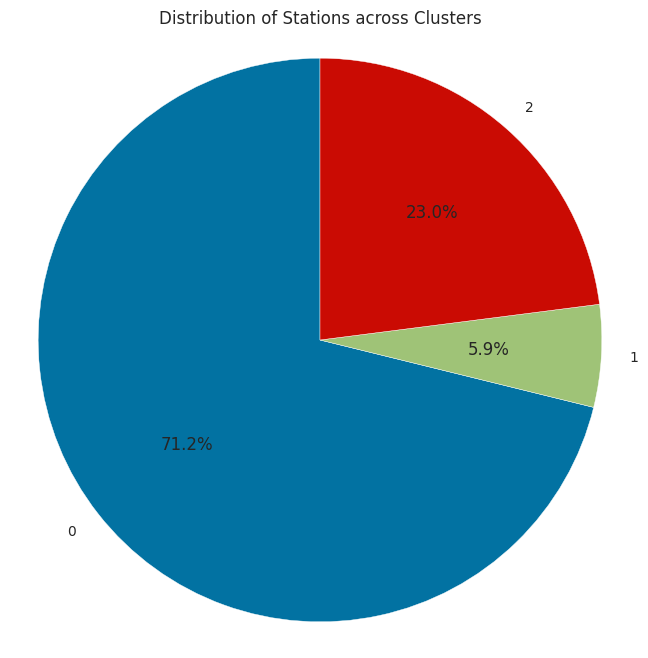

In [ ]:
present_distribution_across_cluster(clusterize_stations_by_frequency(df_freq, 3))

In [ ]:
df_freq

station_id  ride_count
0       3460.01          71
1       3501.01          18
2       3651.04         504
3       3665.06          53
4       3696.05          80
...         ...         ...
1784  Lab - NYC           8
1785     SYS016           5
1786     SYS033           4
1787     SYS035           5
1788     SYS036           2

[1789 rows x 2 columns]

In [ ]:
geoclusterized = clusterize_by_geolocation(df_base, 4)

In [ ]:
present_geolocation_of_clusters(geoclusterized, ['red', 'blue', 'green', 'purple'])

In [ ]:
subway_stations = pd.read_csv('/content/MTA_Subway_Stations_20250217.csv')

In [ ]:
predictions

In [ ]:
df_t = df_base.copy()

In [ ]:
n, cl = features_timestamp(df_t)
n.drop(cl, axis=1, inplace=True)
n[['ride_id', 'start_station_id', 'day', 'hour', 'start_lat', 'start_lng']]

ride_id start_station_id  day  hour  start_lat  start_lng
0       7FB44ACE772F2B5E          6584.12   16    11  40.755103 -73.974987
1       514091422D32E0D4          5763.03   15    12  40.730386 -74.002150
2       C094CBA14014648D          5763.03    2     8  40.730386 -74.002150
3       6675D4453C4DBFE4          5763.03   24    12  40.730386 -74.002150
4       FE65CE25E01D48B7          5763.03   16    13  40.730386 -74.002150
...                  ...              ...  ...   ...        ...        ...
999995  FDFAA91D86E2059D          4903.08   27     9  40.702772 -73.993836
999996  EA661DCFA4C66718          4903.08   15     8  40.702772 -73.993836
999997  47B320DB0D14AFCB          4903.08   30     9  40.702772 -73.993836
999998  BBA56A71525EE91A          4903.08   16     9  40.702772 -73.993836
999999  2F08FA69192BF006          4903.08   17     9  40.702772 -73.993836

[1000000 rows x 6 columns]

In [ ]:
n = n.groupby(['start_station_id', 'day', 'hour']).agg(
    trip_amount=('ride_id', 'count'),  # Count of 'ride_id'
).reset_index()
n

start_station_id  day  hour  trip_amount
0               3460.01    1    10            2
1               3460.01    2    14            2
2               3460.01    3    13            1
3               3460.01    3    17            1
4               3460.01    3    19            1
...                 ...  ...   ...          ...
415320           SYS035   14    18            1
415321           SYS035   17    23            1
415322           SYS035   30    22            1
415323           SYS036   15    13            1
415324           SYS036   31    22            1

[415325 rows x 4 columns]

In [ ]:
u = df_base[['start_station_id', 'start_lat', 'start_lng']].drop_duplicates(subset=['start_station_id'])
n = pd.merge(n, u, on='start_station_id', how='left')

In [ ]:
n

In [ ]:
a = df_base[['start_station_id', 'start_lat', 'start_lng']].head(5)

In [ ]:
a

In [ ]:
b = subway_stations[['GTFS Latitude', 'GTFS Longitude', 'Station ID']].head(5)

In [ ]:
trip_count = df_base[['start_station_id','ride_id']].groupby('start_station_id').count().reset_index()

In [ ]:
df_station_features = feature_distance_to_subway(a, b)

In [ ]:
df_station_features = df_station_features.merge(trip_count, on='start_station_id').rename(columns={'ride_id': 'trip_count'})

NameError: name 'trip_count' is not defined

In [ ]:
df_station_features

start_station_id  start_lat  start_lng  distance_to_subway
0          6584.12  40.755103 -73.974987            3.839454
1          5763.03  40.730386 -74.002150            6.795581
2          5763.03  40.730386 -74.002150            6.795581
3          5763.03  40.730386 -74.002150            6.795581
4          5763.03  40.730386 -74.002150            6.795581

In [ ]:
mm = pd.merge(
    n,
    df[['day', 'hour', 'trip_amount']],
    on=['day', 'hour'], how='left').rename(
        columns={'trip_amount_x': 'trip_amount','trip_amount_y':'total'})

In [ ]:
mm['share'] = (mm['trip_amount'] / mm['total'])*100

In [ ]:
mm

In [ ]:
xx = pd.merge(
    df_station_features[['start_station_id', 'distance_to_subway']],
    mm,
    on=['start_station_id'], how='left')

In [ ]:
xx.drop(['trip_amount'], axis=1, inplace=True)

In [ ]:
xx

start_station_id  distance_to_subway  day  hour  start_lat  start_lng  \
0             6584.12            3.839454    1    11  40.755103 -73.974987   
1             6584.12            3.839454    1    14  40.755103 -73.974987   
2             6584.12            3.839454    1    17  40.755103 -73.974987   
3             6584.12            3.839454    1    18  40.755103 -73.974987   
4             6584.12            3.839454    2     0  40.755103 -73.974987   
...               ...                 ...  ...   ...        ...        ...   
2790          5763.03            6.795581   31    19  40.730386 -74.002150   
2791          5763.03            6.795581   31    20  40.730386 -74.002150   
2792          5763.03            6.795581   31    21  40.730386 -74.002150   
2793          5763.03            6.795581   31    22  40.730386 -74.002150   
2794          5763.03            6.795581   31    23  40.730386 -74.002150   

      total     share  
0       937  0.106724  
1      1234  0.081037  
2       962  0.103950  
3       961  0.312175  
4       116  0.862069  
...     ...       ...  
2790   2262  0.486295  
2791   1409  0.496806  
2792    573  0.349040  
2793    623  0.321027  
2794    482  0.207469  

[2795 rows x 8 columns]

In [ ]:
xx['start_station_id'].unique()

array(['6584.12', '5763.03'], dtype=object)

In [ ]:
station_setups = {}
station_models = {}

In [ ]:
for station_id in xx['start_station_id'].unique():
  station_setups[station_id] = setup(
    data=xx,
    target='share',
    numeric_features=['day', 'hour', 'distance_to_subway', 'start_lat', 'start_lng', 'total'],
    categorical_features=['start_station_id'],
    use_gpu = True,
    session_id=123)
  best_model = compare_models()
  station_models[station_id] = create_model('xgboost')

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
evaluate_model(station_models['6584.12'])

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
predictions_station = predict_model(station_models['6584.12'])
predictions_station

start_station_id  distance_to_subway  day  hour  start_lat  start_lng  \
2444          5763.03            6.795580   14     0  40.730385 -74.002151   
1733          5763.03            6.795580    7    15  40.730385 -74.002151   
991           5763.03            6.795580   30     6  40.730385 -74.002151   
1740          5763.03            6.795580    7    22  40.730385 -74.002151   
189           6584.12            3.839454   14    10  40.755104 -73.974983   
...               ...                 ...  ...   ...        ...        ...   
1683          5763.03            6.795580    5     0  40.730385 -74.002151   
275           6584.12            3.839454   21     7  40.755104 -73.974983   
2703          5763.03            6.795580   27    11  40.730385 -74.002151   
611           5763.03            6.795580   10    13  40.730385 -74.002151   
1857          5763.03            6.795580   14     1  40.730385 -74.002151   

      total     share  prediction_label  
2444    233  0.429185          0.461210  
1733   1793  0.223090          0.245818  
991    1044  0.287356          0.284351  
1740    668  0.598802          0.595206  
189    1623  0.246457          0.325170  
...     ...       ...               ...  
1683    345  0.869565          0.861629  
275    2036  0.736739          0.537261  
2703   1278  0.156495          0.200240  
611    1900  0.421053          0.326038  
1857    108  0.925926          0.915713  

[839 rows x 9 columns]

In [ ]:
df.head()

In [ ]:
present_subway_locations(subway_stations)